### Introduction

In this notebook, I'm trying to integrate the public notebook for Ventillator Pressure Competition written in Pytorch to Fastai. The reason is to leverage high level API of fastai to avoid repetitive pattern ( for example fititing with a scheduler learning rate, adding some callback  like ReduceLROnPlateau )


In [1]:
!pip install -Uqq fastai

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from torch.utils.data import Dataset
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
from fastai.data.core import DataLoaders
from fastai.learner import Learner
from fastai.callback.progress import ProgressCallback
from fastai.optimizer import OptimWrapper
from torch import optim
from fastai.losses import MSELossFlat, L1LossFlat
from fastai.callback.schedule import Learner
from fastai.callback.tracker import EarlyStoppingCallback, ReduceLROnPlateau, SaveModelCallback
from fastai.data.transforms import IndexSplitter
from sklearn.preprocessing import RobustScaler, normalize
from sklearn.model_selection import KFold
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import random
import gc

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ventilator-pressure-prediction/sample_submission.csv
/kaggle/input/ventilator-pressure-prediction/train.csv
/kaggle/input/ventilator-pressure-prediction/test.csv


In [3]:
df = pd.read_csv('/kaggle/input/ventilator-pressure-prediction/train.csv')
df_test = pd.read_csv('../input/ventilator-pressure-prediction/test.csv')

In [4]:
# max_size = 100

In [5]:
# df = df[df.breath_id < max_size]

In [6]:
def add_features(df):
    df['area'] = df['time_step'] * df['u_in']
    df['area'] = df.groupby('breath_id')['area'].cumsum()
    df['cross']= df['u_in']*df['u_out']
    df['cross2']= df['time_step']*df['u_out']
    
    df['u_in_cumsum'] = (df['u_in']).groupby(df['breath_id']).cumsum()
    df['one'] = 1
    df['count'] = (df['one']).groupby(df['breath_id']).cumsum()
    df['u_in_cummean'] =df['u_in_cumsum'] /df['count']
    df['breath_id_lag']=df['breath_id'].shift(1).fillna(0)
    df['breath_id_lag2']=df['breath_id'].shift(2).fillna(0)
    df['breath_id_lagsame']=np.select([df['breath_id_lag']==df['breath_id']],[1],0)
    df['breath_id_lag2same']=np.select([df['breath_id_lag2']==df['breath_id']],[1],0)
    df['u_in_lag'] = df['u_in'].shift(1).fillna(0)
    df['u_in_lag'] = df['u_in_lag']*df['breath_id_lagsame']
    df['u_in_lag2'] = df['u_in'].shift(2).fillna(0)
    df['u_in_lag2'] = df['u_in_lag2']*df['breath_id_lag2same']
    df['u_out_lag2'] = df['u_out'].shift(2).fillna(0)
    df['u_out_lag2'] = df['u_out_lag2']*df['breath_id_lag2same']
    #df['u_in_lag'] = df['u_in'].shift(2).fillna(0)
    
    df['R'] = df['R'].astype(str)
    df['C'] = df['C'].astype(str)
    df['RC'] = df['R']+df['C']
    df = pd.get_dummies(df)
    return df


train = add_features(df)
test = add_features(df_test)

In [7]:
targets = train[['pressure']].to_numpy().reshape(-1, 80)
train.drop(['pressure','id', 'breath_id','one','count','breath_id_lag','breath_id_lag2','breath_id_lagsame','breath_id_lag2same','u_out_lag2'], axis=1, inplace=True)
test = test.drop(['id', 'breath_id','one','count','breath_id_lag','breath_id_lag2','breath_id_lagsame','breath_id_lag2same','u_out_lag2'], axis=1)

In [8]:
RS = RobustScaler()
train = RS.fit_transform(train)
test = RS.transform(test)

In [9]:
train = train.reshape(-1, 80, train.shape[-1])
test = test.reshape(-1, 80, train.shape[-1])

In [10]:
idx = list(range(len(train)))

In [11]:
# train_input, valid_input = train[:3000], train[3000:4000]
# train_targets, valid_targets = targets[:3000], targets[3000:4000]

In [12]:
train.shape[-2:]

(80, 25)

In [13]:
class VentilatorDataset(Dataset):
    def __init__(self, data, target):
        self.data = torch.from_numpy(data).float()
        if target is not None:
            self.targets = torch.from_numpy(target).float()
                
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if hasattr(self, 'targets'): return self.data[idx], self.targets[idx]
        else: return self.data[idx]

In [14]:
class RNNModel(nn.Module):
    def __init__(self, input_size=25):
        hidden = [500, 400, 300, 200]
        super().__init__()
        self.lstm1 = nn.LSTM(input_size, hidden[0],
                             batch_first=True, bidirectional=True)
        self.lstm2 = nn.LSTM(2 * hidden[0], hidden[1],
                             batch_first=True, bidirectional=True)
        self.lstm3 = nn.LSTM(2 * hidden[1], hidden[2],
                             batch_first=True, bidirectional=True)
        self.lstm4 = nn.LSTM(2 * hidden[2], hidden[3],
                             batch_first=True, bidirectional=True)
        self.fc1 = nn.Linear(2 * hidden[3], 50)
        self.selu = nn.SELU()
        self.fc2 = nn.Linear(50, 1)
        self._reinitialize()

    def _reinitialize(self):
        """
        Tensorflow/Keras-like initialization
        """
        for name, p in self.named_parameters():
            if 'lstm' in name:
                if 'weight_ih' in name:
                    nn.init.xavier_uniform_(p.data)
                elif 'weight_hh' in name:
                    nn.init.orthogonal_(p.data)
                elif 'bias_ih' in name:
                    p.data.fill_(0)
                    # Set forget-gate bias to 1
                    n = p.size(0)
                    p.data[(n // 4):(n // 2)].fill_(1)
                elif 'bias_hh' in name:
                    p.data.fill_(0)
            elif 'fc' in name:
                if 'weight' in name:
                    nn.init.xavier_uniform_(p.data)
                elif 'bias' in name:
                    p.data.fill_(0)

    def forward(self, x):
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x, _ = self.lstm3(x)
        x, _ = self.lstm4(x)
        x = self.fc1(x)
        x = self.selu(x)
        x = self.fc2(x)

        return x

In [15]:
# next(model.parameters())

In [16]:
batch_size = 512
submission = pd.read_csv('../input/ventilator-pressure-prediction/sample_submission.csv')
test_dataset = VentilatorDataset(test, None)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False)

In [17]:
########################## Experimenting with one fold

In [18]:
train_index=list(range(int(0.95*len(train)))) ## Change to have reasonable train/valid dataset
valid_index=list(range(int(0.95*len(train)), len(train)))

train_input, valid_input = train[train_index], train[valid_index]
train_targets, valid_targets = targets[train_index], targets[valid_index]

train_dataset = VentilatorDataset(train_input, train_targets)
valid_dataset = VentilatorDataset(valid_input, valid_targets)

train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size = batch_size, shuffle=False)

dls = DataLoaders(train_loader, valid_loader)
model = RNNModel()


SuggestedLRs(valley=0.0004786300996784121)

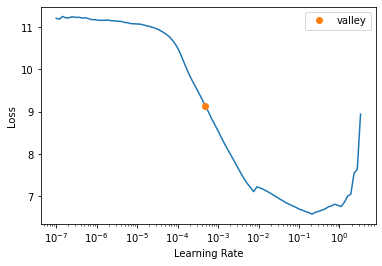

In [19]:
learn = Learner(dls, model, loss_func=L1LossFlat())
learn.lr_find()

In [20]:
del df
gc.collect()

14687

In [21]:
learn.fit_one_cycle(350, lr_max=2e-3, cbs=[ReduceLROnPlateau(monitor='valid_loss', min_delta=0.5, patience=10), SaveModelCallback(every_epoch=True)])
preds = []
with torch.no_grad():
    for data in test_loader:
        pred = model(data.to('cuda')).squeeze(-1).flatten()
        preds.extend(pred.detach().cpu().numpy())
# preds_fold.append(preds)
df_test['pressure'] = preds
df_test[['id', 'pressure']].to_csv('submission.csv', index=False)

epoch,train_loss,valid_loss,time
0,2.286568,1.476864,00:55
1,1.175853,1.031326,00:55
2,0.966790,0.907270,00:55
3,0.897444,0.893423,00:55
4,0.843903,0.813873,00:55
5,0.801264,0.768787,00:55
6,0.763063,0.754198,00:55
7,0.736696,0.718640,00:55
8,0.708346,0.683202,00:55
9,0.680280,0.661406,00:55


Epoch 12: reducing lr to 1.8257560518028315e-05
Epoch 22: reducing lr to 3.889616917446942e-05
Epoch 41: reducing lr to 9.794753707951876e-05
Epoch 51: reducing lr to 0.0001319983476050639
Epoch 61: reducing lr to 0.0001624785220378587
Epoch 71: reducing lr to 0.0001855009163050372
Epoch 81: reducing lr to 0.00019812948238688658
Epoch 91: reducing lr to 0.00019985547377786257
Epoch 101: reducing lr to 0.00019849953627114727
Epoch 111: reducing lr to 0.00019573446473148976
Epoch 121: reducing lr to 0.00019159981140822366
Epoch 131: reducing lr to 0.00018615473553262673
Epoch 141: reducing lr to 0.00017947713177140167
Epoch 151: reducing lr to 0.00017166253089630207
Epoch 161: reducing lr to 0.00016282272608315575
Epoch 171: reducing lr to 0.00015308418777402712
Epoch 181: reducing lr to 0.0001425862336510044
Epoch 191: reducing lr to 0.00013147904897440956
Epoch 201: reducing lr to 0.00011992153474557569
Epoch 211: reducing lr to 0.00010807903444598404
Epoch 221: reducing lr to 9.612097

In [22]:
########################################################################## Uncomment code below KFold Prediction

In [23]:
# kf = KFold(n_splits=5, shuffle=True)
# preds_fold = []
        
# for fold, (train_index, valid_index) in enumerate(kf.split(idx)):
#     preds = []
#     model = RNNModel().to('cuda')
#     print("FOLD:", fold)
#     print(train_index)
#     print(valid_index)

#     train_input, valid_input = train[train_index], train[valid_index]
#     train_targets, valid_targets = targets[train_index], targets[valid_index]

#     train_dataset = VentilatorDataset(train_input, train_targets)
#     valid_dataset = VentilatorDataset(valid_input, valid_targets)
    
#     train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
#     valid_loader = DataLoader(valid_dataset, batch_size = batch_size, shuffle=False)
    
#     dls = DataLoaders(train_loader, valid_loader)
#     learn = Learner(dls, model, loss_func=MSELossFlat())
#     learn.fit_one_cycle(1, lr_max=2e-3)
    
#     with torch.no_grad():
#         for data in test_loader:
#             pred = model(data.to('cuda')).squeeze(-1).flatten()
#             preds.extend(pred.detach().cpu().numpy())
#     preds_fold.append(preds)

In [24]:
# preds_fold = np.array(preds_fold)
# df_test['pressure'] = np.median(preds_fold, axis=0)
# df_test[['id', 'pressure']].to_csv('submission.csv', index=False)